In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import os
import numpy as np
import func
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('./instance/model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./instance/test/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(test_generator)
# print('test loss, test acc:', results)

Found 39900 images belonging to 3 classes.



It tooks 3 seconds

index are predictions, columns are ground truth



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
Canon_Ixus70,78,1,0
Olympus_mju-1050SW,0,69,0
Nikon_D200,0,0,172


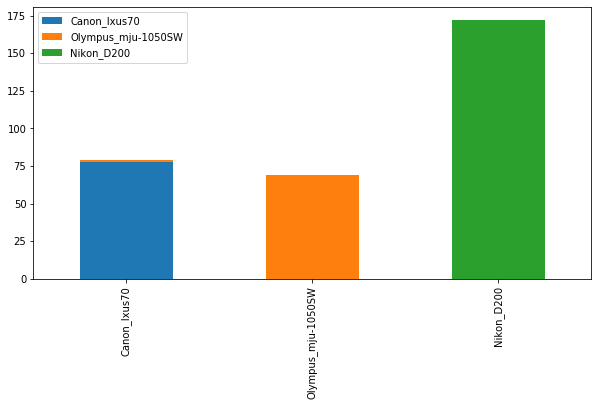

In [5]:
model_list = os.listdir(r'./instance/test/')
# generate a histogram, which for every unseen models, how many imgs are classified.
hist, conf, labels = func.evaluate(model_list, test_generator, model, index=model_list, columns=model_list, title=None, num_batch=5)

The mean of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.986584,0.012560,0.000856
1.0,0.005024,0.988379,0.006598
2.0,0.000592,0.001864,0.997544


The standard deviation of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.077111,0.073743,0.003789
1.0,0.016790,0.050882,0.036858
2.0,0.004002,0.019384,0.020125


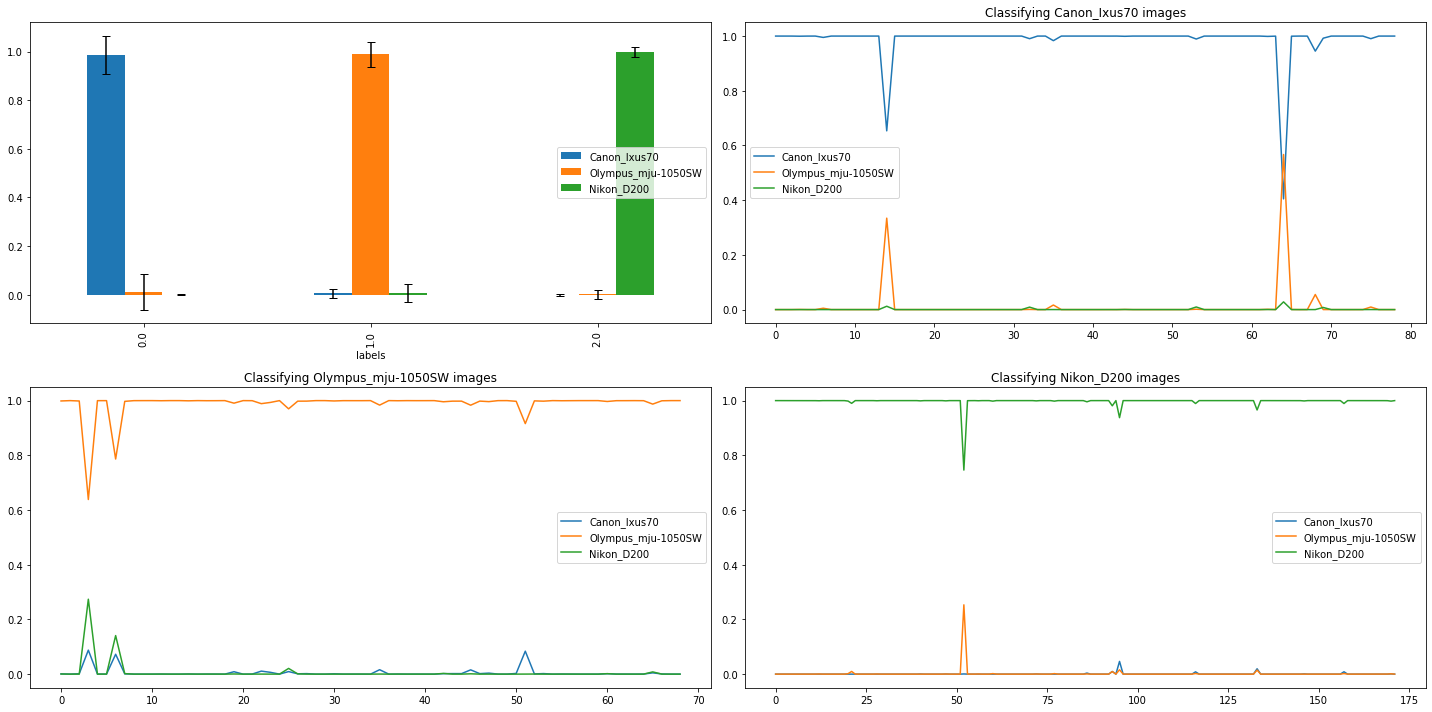

In [6]:
mean, error = func.mean_error(labels, conf, model_list)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
mean.plot.bar(yerr=error, ax=axes[0,0], capsize=4)

# for all the images' real label is a certain camera, for example Canon_Ixus70, 
# how does these images are classified ? The magnitude of the histogram indicate how
# sure is the model classified the image as one camera(show by color)
graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}

func.plot_conf(model_list, labels, conf, graph)